# Data Cleaning using Spark Streaming

[Apache Spark](https://spark.apache.org/) is a unified analytics engine for large-scale data processing. It gives you a high-level API to do high-performant data processing. 

In the previous lab, you used Spark to process large volumes of data interactively and in batch. However, Spark also has two API's for streaming data, which this lab will focus on. This exercise uses the Spark streaming API (DStream) to clean the page view event stream.

* Remove messages that don't have a timestamp or that whose timestamp is 0.
* Cast all country codes to uppercase.
* Remove all countries except Belgium

The resulting stream will be sent back to kafka, in a new topic `clicks-cleaned`.

The DStream api is not a *true* streaming api because it doesn't process events immediately as it recieves them. The DStream API works on a micro batch. Spark polls the event source after every batch duration and processes all events since the last poll once. This means that, if your batch duration is 30 seconds, it might take 30 seconds for an event to be processed in the worst case.

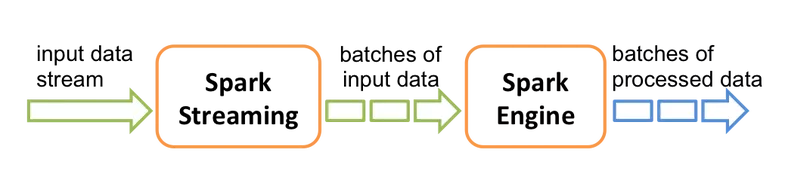

Spark also has a true streaming api called "structured streams", which will is part of the next exercise.

* [More info on DStreams vs structured streams](https://blog.knoldus.com/spark-streaming-vs-structured-streaming/)

In [1]:
%%bash
python3 -m pip install kafka-python

Create a Spark context and specify that the python spark-kafka libraries need to be added.

In [2]:
import os
# Add python Spark streaming libraries to spark job.
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-streaming-kafka-0-8_2.11:2.4.3 pyspark-shell'

from pyspark import SparkContexts
import json

# Create Spark context
sc = SparkContext()
sc.setLogLevel("WARN")




Then we create a Spark streaming context. It's important to only import the pyspark streaming modules *after* the Spark context is created.

In [3]:
from pyspark.streaming import StreamingContext

# Create Spark Streaming context
ssc = StreamingContext(sc, 30)


Next we create a 

In [4]:
from pyspark.streaming.kafka import KafkaUtils
# Get the input stream from the `clicks` topic in kafka
directKafkaStream = KafkaUtils.createDirectStream(ssc, ['clicks'], {"metadata.broker.list": 'localhost:9092'}, 
                                                 messageHandler=lambda x: json.loads(x.message))




Use a filter to remove messages that don't have a `ts_ingest` field or whose timestamp is empty.

In [5]:
# Remove message without a 'ts_ingest' field or empty timestamps
filtered_ts = directKafkaStream.filter(lambda x: 'ts_ingest' in x.keys() and x['ts_ingest'])


Use a `map` with a custom function to convert all `visitor_country` fields to uppercase.

In [6]:
# Ensure data uniformity, all country codes should be uppercase
def country_to_upper(data):
    data['visitor_country'] = data['visitor_country'].upper()
    return data
uppercase_country = filtered_ts.map(country_to_upper)


Use a `filter` to drop all records whose country is not `BE`.


In [ ]:
# Filter on only clicks from BE
filtered_be = uppercase_country.filter(lambda x: 'visitor_country' in x.keys() and x['visitor_country'] == 'BE')

Send the result to the kafka topic `clicks-cleaned` by using `foreachRDD` and `rdd.collect()`.

In [7]:
import json
from kafka import KafkaProducer
from kafka.errors import KafkaError

producer = KafkaProducer(bootstrap_servers=['localhost:9092'],
                         value_serializer=lambda v: json.dumps(v).encode('utf-8'))

def send_record(rdd):
    records = rdd.collect()
    for r in records:
        producer.send('clicks-ttesst', r)
        producer.flush()
# Send the result back to Kafka
filtered_be.foreachRDD(send_record)

Finally, start the streaming job.

In [8]:
ssc.start()
ssc.awaitTermination()

KeyboardInterrupt: 